In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.layers import LSTM
from keras.models import Sequential, load_model
# from pyswarm import pso
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ReduceLROnPlateau
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense, Activation, Conv1D, MaxPooling1D, Flatten, Reshape,Bidirectional,Input
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
import time  # 引入time模块
from keras.layers import Multiply, Permute, Lambda, RepeatVector
from tensorflow.keras.layers import Layer, Dense, Multiply

In [2]:
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [3]:
import numpy as np
import pandas as pd

def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance


def createSequence(data, window, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['MMSI']):
        data_temp = data.loc[data['MMSI'] == traj_id]
        first_lon = data_temp.loc[data_temp.index[0], 'Lon']
        first_lat = data_temp.loc[data_temp.index[0], 'Lat']
        end_lon = data_temp.loc[data_temp.index[-1], 'Lon']
        end_lat = data_temp.loc[data_temp.index[-1], 'Lat']

        data_temp = np.array(data_temp.loc[:, ['Lon', 'Lat', 'SOG', 'COG']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label


# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true

In [4]:
class AttentionBlock(Layer):
    def __init__(self, input_dim, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        self.input_dim = input_dim
        # 定义 Dense 层用于计算注意力权重
        self.attention_dense = Dense(input_dim, activation='softmax')

    def call(self, inputs):
        # 计算注意力权重，不进行转置
        attention_weights = self.attention_dense(inputs)
        # 应用注意力权重到输入上，形状必须一致
        output_attention = Multiply()([inputs, attention_weights])
        return output_attention

    def get_config(self):
        config = super(AttentionBlock, self).get_config()
        config.update({'input_dim': self.input_dim})
        return config

def trainModel(train_X, train_Y, test_X, test_Y):
    model = Sequential()

   # 使用自定义的 AttentionBlock 替代 Lambda 层
    model.add(AttentionBlock(input_dim=train_X.shape[2], input_shape=(train_X.shape[1], train_X.shape[2])))
    
    # GRU层
    model.add(GRU(100, return_sequences=False))  # 使用GRU单元
    model.add(Dropout(0.5))  # Dropout层，防止过拟合
    
    # 输出层
    model.add(Dense(train_Y.shape[1]))  # 输出层，输出维度与标签维度相同
    model.add(Activation("relu"))  # 使用ReLU激活函数

    # 使用Adam优化器
    adam = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])  # 使用均方误差（MSE）作为损失函数

    # 记录训练日志
    log = CSVLogger(f"./log_sta_gru.csv", separator=",", append=True)

    # 开始训练模型
    model.fit(train_X, train_Y, epochs=200, batch_size=64, verbose=1, validation_split=0.1, callbacks=[log])

    # 模型评估
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))

    # 保存模型
    model.save(f"./sta_gru_model.h5")

    # 打印模型结构
    model.summary()

    return model

In [5]:
# 获取数据
train = pd.read_csv("./train.csv",index_col=0)
test = pd.read_csv("./test.csv",index_col=0)

In [6]:
# 计算归一化参数
nor = np.array(train.loc[:, ['Lon', 'Lat', 'SOG', 'COG']])

m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 20
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)

In [21]:
# 记录整个过程的开始时间
start_time = time.time()

# 训练模型
model = trainModel(train_seq, train_label,test_seq,test_label)

# 记录训练结束时间
end_time = time.time()

total_time = end_time - start_time
print(f"模型训练和评估总耗时: {total_time:.2f} 秒")

Epoch 1/200
2702/2702 [==============================] - 25s 9ms/step - loss: 0.0050 - acc: 0.9204 - val_loss: 8.0089e-04 - val_acc: 0.9675
Epoch 2/200
2702/2702 [==============================] - 24s 9ms/step - loss: 0.0018 - acc: 0.9520 - val_loss: 7.4386e-04 - val_acc: 0.9628
Epoch 3/200
2702/2702 [==============================] - 24s 9ms/step - loss: 0.0018 - acc: 0.9505 - val_loss: 7.3777e-04 - val_acc: 0.9740
Epoch 4/200
2702/2702 [==============================] - 24s 9ms/step - loss: 0.0018 - acc: 0.9507 - val_loss: 7.4097e-04 - val_acc: 0.9749
Epoch 5/200
2702/2702 [==============================] - 24s 9ms/step - loss: 0.0017 - acc: 0.9502 - val_loss: 7.6962e-04 - val_acc: 0.9688
Epoch 6/200
2702/2702 [==============================] - 24s 9ms/step - loss: 0.0017 - acc: 0.9519 - val_loss: 6.9537e-04 - val_acc: 0.9729
Epoch 7/200
2702/2702 [==============================] - 24s 9ms/step - loss: 0.0017 - acc: 0.9516 - val_loss: 7.5595e-04 - val_acc: 0.9703
Epoch 8/200
2702/270

2702/2702 [==============================] - 25s 9ms/step - loss: 0.0016 - acc: 0.9547 - val_loss: 6.8380e-04 - val_acc: 0.9755
Epoch 60/200
2702/2702 [==============================] - 25s 9ms/step - loss: 0.0016 - acc: 0.9551 - val_loss: 6.8710e-04 - val_acc: 0.9791
Epoch 61/200
2702/2702 [==============================] - 25s 9ms/step - loss: 0.0016 - acc: 0.9548 - val_loss: 6.9316e-04 - val_acc: 0.9729
Epoch 62/200
2702/2702 [==============================] - 25s 9ms/step - loss: 0.0016 - acc: 0.9546 - val_loss: 6.8093e-04 - val_acc: 0.9752
Epoch 63/200
2702/2702 [==============================] - 25s 9ms/step - loss: 0.0016 - acc: 0.9553 - val_loss: 7.0119e-04 - val_acc: 0.9729
Epoch 64/200
2702/2702 [==============================] - 25s 9ms/step - loss: 0.0016 - acc: 0.9550 - val_loss: 7.0733e-04 - val_acc: 0.9769
Epoch 65/200
2702/2702 [==============================] - 24s 9ms/step - loss: 0.0016 - acc: 0.9542 - val_loss: 6.9730e-04 - val_acc: 0.9745
Epoch 66/200
2702/2702 [==

2702/2702 [==============================] - 25s 9ms/step - loss: 0.0016 - acc: 0.9548 - val_loss: 7.1238e-04 - val_acc: 0.9692
Epoch 118/200
2702/2702 [==============================] - 25s 9ms/step - loss: 0.0016 - acc: 0.9550 - val_loss: 6.7002e-04 - val_acc: 0.9763
Epoch 119/200
2702/2702 [==============================] - 26s 9ms/step - loss: 0.0016 - acc: 0.9555 - val_loss: 7.2385e-04 - val_acc: 0.9731
Epoch 120/200
2702/2702 [==============================] - 25s 9ms/step - loss: 0.0016 - acc: 0.9547 - val_loss: 7.0318e-04 - val_acc: 0.9780
Epoch 121/200
2702/2702 [==============================] - 26s 9ms/step - loss: 0.0016 - acc: 0.9557 - val_loss: 7.1794e-04 - val_acc: 0.9766
Epoch 122/200
2702/2702 [==============================] - 26s 9ms/step - loss: 0.0016 - acc: 0.9548 - val_loss: 6.8586e-04 - val_acc: 0.9741
Epoch 123/200
2702/2702 [==============================] - 26s 9ms/step - loss: 0.0016 - acc: 0.9556 - val_loss: 6.9788e-04 - val_acc: 0.9793
Epoch 124/200
2702/2

2702/2702 [==============================] - 25s 9ms/step - loss: 0.0015 - acc: 0.9549 - val_loss: 7.1059e-04 - val_acc: 0.9726
Epoch 175/200
2702/2702 [==============================] - 25s 9ms/step - loss: 0.0015 - acc: 0.9544 - val_loss: 7.0446e-04 - val_acc: 0.9780
Epoch 176/200
2702/2702 [==============================] - 26s 10ms/step - loss: 0.0015 - acc: 0.9545 - val_loss: 6.8778e-04 - val_acc: 0.9770
Epoch 177/200
2702/2702 [==============================] - 25s 9ms/step - loss: 0.0016 - acc: 0.9542 - val_loss: 6.8694e-04 - val_acc: 0.9751
Epoch 178/200
2702/2702 [==============================] - 26s 10ms/step - loss: 0.0016 - acc: 0.9524 - val_loss: 7.3559e-04 - val_acc: 0.9717
Epoch 179/200
2702/2702 [==============================] - 26s 9ms/step - loss: 0.0016 - acc: 0.9542 - val_loss: 7.1090e-04 - val_acc: 0.9749
Epoch 180/200
2702/2702 [==============================] - 26s 9ms/step - loss: 0.0015 - acc: 0.9552 - val_loss: 6.9776e-04 - val_acc: 0.9761
Epoch 181/200
2702

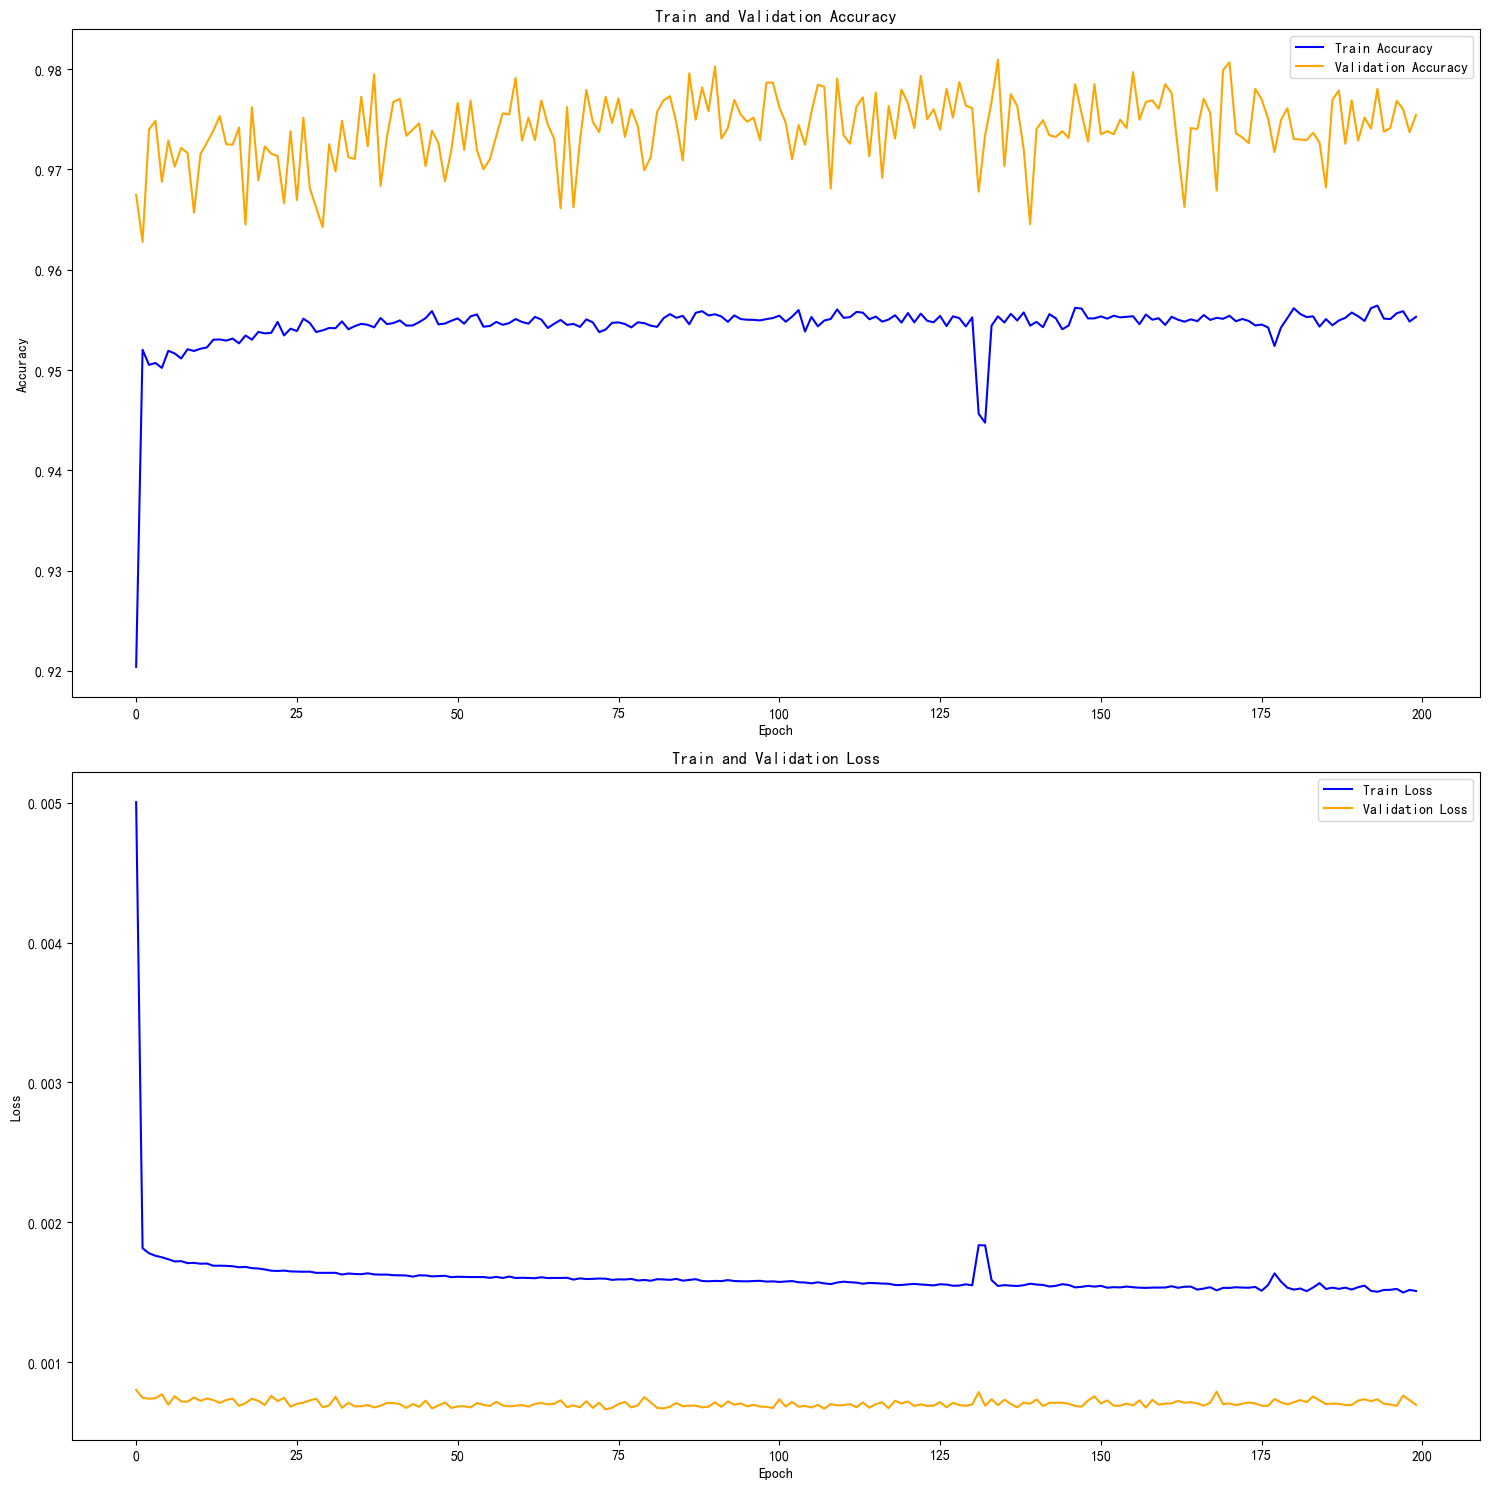

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.read_csv("./log_sta_gru.csv")

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

# Plot accuracy
ax[0].plot(logs['epoch'], logs['acc'], label='Train Accuracy', color='blue')
ax[0].plot(logs['epoch'], logs['val_acc'], label='Validation Accuracy', color='orange')
ax[0].set_title('Train and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(logs['epoch'], logs['loss'], label='Train Loss', color='blue')
ax[1].plot(logs['epoch'], logs['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Train and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [7]:
from keras.models import load_model
import numpy as np
from tensorflow.keras.models import load_model

# 如果使用了自定义层 AttentionBlock，需要提供 custom_objects 参数
model = load_model('sta_gru_model.h5', custom_objects={'AttentionBlock': AttentionBlock})

test_points_ids = list(set(test['MMSI']))
BP_error_list = []
BP_Pre0 = []
BP_Pre1 = []
BP_Pre2 = []
BP_Pre3 = []
BP_Tre0 = []
BP_Tre1 = []
BP_Tre2 = []
BP_Tre3 = []
for ids in test_points_ids:
    test_seq, test_label = createSequence(test.loc[test.MMSI == ids], windows, maxmin)
    # 要预测的时间
    pre_time = 10
    # 单值预测
    y_pre_BP_50, y_pre_lstm_50, y_pre_GRU_50, y_pre_biLSTM_50, y_pre_bigru_50, y_pre_CNN_RGRU_Attention_50 = [], [], [], [], [], []
    y_true = []

#     for start_id in range(test_seq.shape[0]-int(pre_time)):
    start_id = 0
    pre_seq = test_seq[start_id]
        # 循环预测
    for i in range(int(pre_time)):
        y_hat_BP_50 =model.predict(pre_seq.reshape(1, windows, 4))
            # 其他模型的预测类似...

        y_pre_BP_50.append(y_hat_BP_50[0])
            # 将其他模型的预测结果也添加到相应的列表中...

        y_true.append(test_label[start_id+i])
        # 下一个数组，把预测的值作为预测序列的最后一个值，实现循环预测
        pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_hat_BP_50, axis=0)[1:]
            
    y_pre_BP_50 = np.array(y_pre_BP_50, dtype='float64')
#         y_pre_lstm_50 = np.array(y_pre_lstm_50, dtype='float64')
#         y_pre_GRU_50 = np.array(y_pre_GRU_50, dtype='float64')
#         y_pre_biLSTM_50 = np.array(y_pre_biLSTM_50, dtype='float64')
#         y_pre_bigru_50 = np.array(y_pre_bigru_50, dtype='float64')
#         y_pre_CNN_RGRU_Attention_50 = np.array(y_pre_CNN_RGRU_Attention_50, dtype='float64')

    y_true = np.array(y_true, dtype='float64')
        # 对预测结果进行归一化处理
    f_y_pre_BP_50, f_y_true = FNormalizeMult(y_pre_BP_50, y_true, maxmin)
        # 对其他模型的预测结果也进行相同的处理
#         f_y_pre_lstm_50, f_y_true = FNormalizeMult(y_pre_lstm_50, y_true, maxmin)
#         f_y_pre_GRU_50, f_y_true = FNormalizeMult(y_pre_GRU_50, y_true, maxmin)
#         f_y_pre_biLSTM_50, f_y_true = FNormalizeMult(y_pre_biLSTM_50, y_true, maxmin)
#         f_y_pre_bigru_50, f_y_true = FNormalizeMult(y_pre_bigru_50, y_true, maxmin)
#         f_y_pre_CNN_RGRU_Attention_50, f_y_true = FNormalizeMult(y_pre_CNN_RGRU_Attention_50, y_true, maxmin)


    BP_Pre0.append(list(np.array(f_y_pre_BP_50)[:, 0]))
    BP_Pre1.append(list(np.array(f_y_pre_BP_50)[:, 1]))
    BP_Pre2.append(list(np.array(f_y_pre_BP_50)[:, 2]))
    BP_Pre3.append(list(np.array(f_y_pre_BP_50)[:, 3]))
    BP_Tre0.append(list(np.array(f_y_true)[:, 0]))
    BP_Tre1.append(list(np.array(f_y_true)[:, 1]))
    BP_Tre2.append(list(np.array(f_y_true)[:, 2]))
    BP_Tre3.append(list(np.array(f_y_true)[:, 3]))
    # 将结果添加到错误列表中
#     BP_error_list.append(list(np.array(y_pre_BP_50)[:, 4]))
    # 将其他模型的结果也添加到相应的列表中...


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


In [8]:
BPP0_data = [item for sublist in BP_Pre0 for item in sublist]
# print(BPP0_data)
BPP1_data = [item for sublist in BP_Pre1 for item in sublist]
# print(BPP1_data)
BPP2_data = [item for sublist in BP_Pre2 for item in sublist]
# print(BPP2_data)
BPP3_data = [item for sublist in BP_Pre3 for item in sublist]
# print(BPP3_data)
BPT0_data = [item for sublist in BP_Tre0 for item in sublist]
# print(BPT0_data)
BPT1_data = [item for sublist in BP_Tre1 for item in sublist]
# print(BPT1_data)
BPT2_data = [item for sublist in BP_Tre2 for item in sublist]
# print(BPT2_data)
BPT3_data = [item for sublist in BP_Tre3 for item in sublist]
# print(BPT3_data)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(BPT0_data, BPP0_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT0_data, BPP0_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT0_data, BPP0_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT1_data, BPP1_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT1_data, BPP1_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT1_data, BPP1_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT2_data, BPP2_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT2_data, BPP2_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT2_data, BPP2_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT3_data, BPP3_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT3_data, BPP3_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT3_data, BPP3_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")

平均绝对误差（MAE）: 0.06713946362000393
均方根误差（MSE）: 0.009565461357582804
均方根误差（RMSE）: 0.09780317662316906
R2分数（R2_score）: 0.9881904203713624
--------------------------------------------------
平均绝对误差（MAE）: 0.11064236780334864
均方根误差（MSE）: 0.023684026336516003
均方根误差（RMSE）: 0.15389615439157667
R2分数（R2_score）: 0.969158068588859
--------------------------------------------------
平均绝对误差（MAE）: 1.0207775659298945
均方根误差（MSE）: 2.416668046452372
均方根误差（RMSE）: 1.5545636193004042
R2分数（R2_score）: 0.6183326497941579
--------------------------------------------------
平均绝对误差（MAE）: 16.96131495564163
均方根误差（MSE）: 2070.51166870081
均方根误差（RMSE）: 45.50287538937303
R2分数（R2_score）: 0.7946023986880656
--------------------------------------------------
